In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn

from torch import optim
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split

import copy

In [2]:
def download_stock_data(ticker_symbol):
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker_symbol}?period1=0&period2=9999999999&interval=1d&events=history"
    df = pd.read_csv(url)
    return df

ticker_symbol =  "^GSPC"
df = download_stock_data(ticker_symbol)

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day

df["Delta"] = (df["Close"] - df["Close"].shift(1))/df["Close"].shift(1)*100
df = df.tail(-1).reset_index(drop=True)

print(df.shape)
print(df.columns)

(13515, 11)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Year',
       'Month', 'Day', 'Delta'],
      dtype='object')


In [4]:
#df = df.sample(frac = 1).reset_index(drop = True)

In [5]:
sequence_length = 14

n = df.shape[0]-sequence_length
n_train = int(n*0.8)


X, y, X_test, y_test = [], torch.empty(0), [], torch.empty(0)

cols = ["Delta", "Volume", "Month", "Day"]

mean, std = df[cols].iloc[:n_train].mean(), df[cols].iloc[:n_train].std()

for i in range(n):
    df_ = (df[cols] - mean) / std 
    if( i < n_train ):
        X.append(torch.tensor(df_[cols].iloc[i:i+sequence_length].values, dtype=torch.float32))
        y = torch.cat( (y, torch.tensor([df_["Delta"].iloc[i+sequence_length]], dtype=torch.float32) ) )
    else:
        X_test.append(torch.tensor(df_[cols].iloc[i:i+sequence_length].values, dtype=torch.float32))
        y_test = torch.cat( (y_test, torch.tensor([df_["Delta"].iloc[i+sequence_length]], dtype=torch.float32) ) )

y = torch.unsqueeze(y, -1)
y_test = torch.unsqueeze(y_test, -1)

In [6]:
print("Train: ", [(len(X))] + list(X[0].shape), list(y.shape))
print("Test: ", [len(X_test)] + list(X_test[0].shape), list(y_test.shape))

Train:  [10800, 14, 4] [10800, 1]
Test:  [2701, 14, 4] [2701, 1]


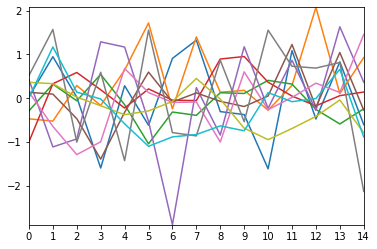

In [7]:
sample = np.random.choice(np.arange(0,len(X)),10)
for i in sample:
    plt.plot(torch.cat([X[i][:,0], y[i]]))
    plt.ylim(min([torch.min(x[:,0]) for x in [X[index] for index in sample]]), 
             max([torch.max(x[:,0]) for x in [X[index] for index in sample]]))
    plt.xticks(np.arange(0,sequence_length+1,1))
    plt.xlim(0, sequence_length)

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        #self.rnn = nn.RNN(input_size = input_size, hidden_size  = hidden_size[0])
        self.rnn = nn.LSTM(input_size=input_size, hidden_size = hidden_size[0])
        nn.init.xavier_normal_(self.rnn.weight_hh_l0)
        
        #self.nn = nn.Linear(hidden_size[0], hidden_size[1])
        #nn.init.xavier_normal_(self.nn.weight)
        
        self.out = nn.Linear(hidden_size[0], output_size)
        nn.init.xavier_normal_(self.out.weight)
        
        self.relu = nn.ReLU()

    def forward(self, X):
        X_padded = pad_sequence(X)
        #output, hidden = self.rnn(X_padded)
        output, (hidden, cell_state) = self.rnn(X_padded)

        y_hat = output[-1]
        y_hat = self.relu(y_hat)     
        
        #y_hat = self.nn(y_hat)
        #y_hat = self.relu(y_hat)     
        
        y_hat = self.out(y_hat)
        
        return y_hat

In [9]:
n_epochs = 200
learning_rate = 0.01
l2_regularization = 0.

input_size = X[0].shape[1] 
hidden_size = [16,16]  
output_size = 1 


model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = l2_regularization)
#optimizer = torch.optim.Adam(model.parameters(), weight_decay = l2_regularization)

In [10]:
# Params
early_stopping = 50
batch_size = 32

track_loss_train = []
track_loss_test = []
stopping_cond = False

for epoch in range(n_epochs):
    # Shuffle the data at the beginning of each epoch
    indices = np.random.permutation(len(X))
    X_shuffled = [X[ind] for ind in indices]
    y_shuffled = y[indices]
    
    for i in range(0, len(X), batch_size):
        optimizer.zero_grad()

        # Extract the mini-batch
        X_mini_batch = X_shuffled[i:i + batch_size]
        y_mini_batch = y_shuffled[i:i + batch_size]
        
        # Forward pass
        y_hat = model(X_mini_batch)
        loss = criterion(y_hat, y_mini_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

    # Track loss on the full training and test sets after each epoch
    with torch.no_grad():
        track_loss_train.append(criterion(model(X), y).item())
        track_loss_test.append(criterion(model(X_test), y_test).item())

    # Analyze loss
    if epoch >= early_stopping:
        if epoch == early_stopping:
            best_params = copy.deepcopy(model.state_dict())
        elif track_loss_test[epoch] < np.min(track_loss_test[early_stopping:epoch]):
            best_params = copy.deepcopy(model.state_dict())

    if early_stopping and (epoch > early_stopping):
        stopping_cond = np.min(track_loss_test[epoch - early_stopping:epoch + 1]) \
        > np.min(track_loss_test[:epoch - early_stopping])

    if stopping_cond:
        print("/!\ Early Stopping")
        break

    if epoch % 20 == 0:
        print("Epoch:", epoch)
        print("Train loss=", track_loss_train[epoch])
        print("Test loss=", track_loss_test[epoch])
        print("-" * 80)

Epoch: 0
Train loss= 1.0003228187561035
Test loss= 1.0125712156295776
--------------------------------------------------------------------------------
Epoch: 20
Train loss= 0.9869797229766846
Test loss= 1.0069924592971802
--------------------------------------------------------------------------------
Epoch: 40
Train loss= 0.9818883538246155
Test loss= 1.0088105201721191
--------------------------------------------------------------------------------
Epoch: 60
Train loss= 0.9786606431007385
Test loss= 1.0068308115005493
--------------------------------------------------------------------------------
Epoch: 80
Train loss= 0.9759777188301086
Test loss= 1.0037599802017212
--------------------------------------------------------------------------------
Epoch: 100
Train loss= 0.9746441841125488
Test loss= 1.006564974784851
--------------------------------------------------------------------------------
Epoch: 120
Train loss= 0.9721648693084717
Test loss= 1.0037847757339478
-----------------

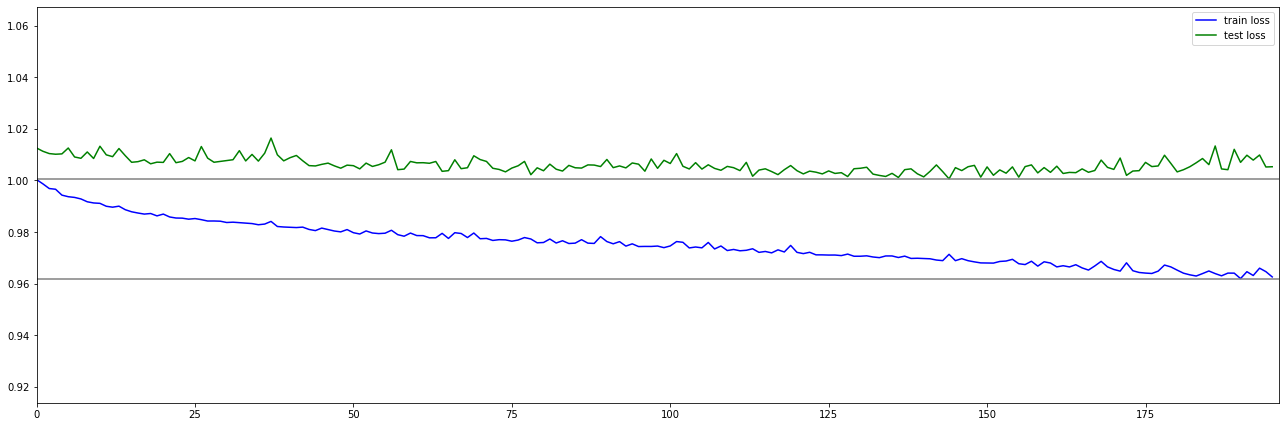

In [11]:
n_iter = len(track_loss_train)

plt.plot(np.arange(0,n_iter), track_loss_train, color = "blue", label="train loss")
plt.plot(np.arange(0,n_iter), track_loss_test, color = "green", label="test loss")
plt.xlim(0,n_iter)
plt.ylim(np.min(track_loss_train)*0.95,np.max(track_loss_test[n_iter//10:])*1.05)
plt.axhline(y=np.min(track_loss_train), color="grey")
plt.axhline(y=np.min(track_loss_test), color="grey")
plt.legend()


plt.subplots_adjust(left=None, bottom=None, right=3, top=1.5, wspace=0.2, hspace=None)

In [12]:
best_rnn = RNN(input_size, hidden_size, output_size)
best_rnn.load_state_dict(best_params)

y_hat = best_rnn(X)
y_hat_test  = best_rnn(X_test)
print("Final results:\n")
print("Train loss:", criterion(y_hat, y).item())
print("Test loss: ", criterion(y_hat_test, y_test).item())

Final results:

Train loss: 0.9713996648788452
Test loss:  1.0006271600723267


In [14]:
'''
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

m, s =  mean["Delta"], std["Delta"]

y_true, y_hat_true, y_test_true, y_hat_test_true = y*s+m, y_hat*s+m, y_test*s+m, y_hat_test*s+m

ax0.plot(y_true.detach().numpy()[-20:], color = 'green', marker  = 'x', linestyle= '', label = "True")
ax0.plot(y_hat_true.detach().numpy()[-20:], color = 'red', marker  = '+', linestyle= '', label = "Predict")
ax0.legend()
ax0.set_title("Train Set");

ax1.plot(y_test_true.detach().numpy()[-20:], color = 'green', marker  = 'x', linestyle= '', label = "True")
ax1.plot(y_hat_test_true.detach().numpy()[-20:], color = 'red', marker  = '+', linestyle= '', label = "Predict")
ax1.legend()
ax1.set_title("Test Set");

plt.subplots_adjust(left=None, bottom=None, right=3, top=1.5, wspace=0.2, hspace=None)
''';